# Colorectal Cancer Classification
In this notebook we will tackle a multiclassification problem. The dataset we will be using comes from kaggle: https://www.kaggle.com/kmader/colorectal-histology-mnist/home 

Our **goal** is as follows:
* Classify tiles correctly into one of the eight classes
* Which classes are most frequently confused?

To do so we will do the following:
* Load all packages 
* Get Kaggle Set up 
* Download all our data 
* Explore our data 
* Using FastAI's DataBlock API - get our data into a DataBunch object with appropriate augmentations
* Test ResNet (Pre-Trained) with DenseNet
* Analyze our data
* Recommend Fine-Tuning mechanisms

In [2]:
# Installing kaggle api
!pip install kaggle --upgrade

    100% |████████████████████████████████| 61kB 21.2MB/s ta 0:00:01
    100% |████████████████████████████████| 133kB 19.2MB/s ta 0:00:01
    100% |████████████████████████████████| 245kB 19.3MB/s ta 0:00:01
  Running setup.py bdist_wheel for kaggle ... done
  Stored in directory: /root/.cache/pip/wheels/0d/58/eb/83d6a2e1935aff39d341ffa1e5faa3809e173cd0937e057d83
  Running setup.py bdist_wheel for python-slugify ... done
  Stored in directory: /root/.cache/pip/wheels/2b/9e/c8/14a18ab55d8f144384de8186a3df8401dcc9264936f71d470f
Successfully built kaggle python-slugify
  Found existing installation: urllib3 1.24.1
    Uninstalling urllib3-1.24.1:
      Successfully uninstalled urllib3-1.24.1


In [3]:
# Importing
from fastai import *
from fastai.vision import *
import torch
from torchvision.models import *

import matplotlib.pyplot as plt

import pandas as pd
import numpy as np
import os

In [4]:
# checking if enabled
torch.backends.cudnn.enabled == True

True

In [5]:
!pwd

/notebooks/course-v3/nbs/dl1


In [6]:
# configuring kaggle
!mkdir .kaggle # we will store in this directory

cred = json.dumps({"username":"USERNAME","key":"KEY"}) # change with your credentials
with open('.kaggle/kaggle.json', 'w') as f:
    f.write(cred) # writes to the .kaggle folder
    
# Configuring the file - we will run this twice (second time next block)
!cp .kaggle/kaggle.json ~/.kaggle/kaggle.json
!kaggle config set -n path -v{/notebooks/course-v3/nbs/dl1}

cp: cannot create regular file '/root/.kaggle/kaggle.json': No such file or directory
Traceback (most recent call last):
  File "/opt/conda/envs/fastai/bin/kaggle", line 7, in <module>
    from kaggle.cli import main
  File "/opt/conda/envs/fastai/lib/python3.6/site-packages/kaggle/__init__.py", line 23, in <module>
    api.authenticate()
  File "/opt/conda/envs/fastai/lib/python3.6/site-packages/kaggle/api/kaggle_api_extended.py", line 116, in authenticate
    self.config_file, self.config_dir))
OSError: Could not find kaggle.json. Make sure it's located in /root/.kaggle. Or use the environment method.


In [7]:
# run for second time
!cp .kaggle/kaggle.json ~/.kaggle/kaggle.json
!kaggle config set -n path -v{/notebooks/course-v3/nbs/dl1}

- path is now set to: {/notebooks/course-v3/nbs/dl1}


In [8]:
# making private
!chmod 600 /root/.kaggle/kaggle.json

In [11]:
# Creating directories and paths
!mkdir cancer_data
!mkdir cancer_data/images # will contain all raw images

path = 'cancer_data'
images_path = 'cancer_data/images'

In [13]:
os.listdir(path)
# os.listdir(images_path)

['images']

In [14]:
# downloading our data
!kaggle datasets download -d kmader/colorectal-histology-mnist -f hmnist_28_28_RGB.csv -p {path}
!kaggle datasets download -d kmader/colorectal-histology-mnist -f Kather_texture_2016_image_tiles_5000.zip -p {path}

 75%|████████████████████████████▌         | 9.00M/12.0M [00:00<00:00, 32.2MB/s]
100%|██████████████████████████████████████| 12.0M/12.0M [00:00<00:00, 38.9MB/s]
 98%|███████████████████████████████████████▎| 242M/246M [00:02<00:00, 93.9MB/s]
100%|████████████████████████████████████████| 246M/246M [00:03<00:00, 86.0MB/s]


In [15]:
os.listdir(path)

['images',
 'hmnist_28_28_RGB.csv.zip',
 'Kather_texture_2016_image_tiles_5000.zip']

In [16]:
# Unzipping files
!unzip -q -n {path}/hmnist_28_28_RGB.csv.zip -d {path} 
!unzip -q -n {path}/Kather_texture_2016_image_tiles_5000.zip -d {images_path}

In [19]:
# Deleting extras
!rm -rf {path}/hmnist_28_28_RGB.csv.zip
!rm -rf {path}/Kather_texture_2016_image_tiles_5000.zip

In [23]:
images_path = f'{images_path}/Kather_texture_2016_image_tiles_5000'
os.listdir(images_path)

['01_TUMOR',
 '02_STROMA',
 '07_ADIPOSE',
 '05_DEBRIS',
 '03_COMPLEX',
 '06_MUCOSA',
 '04_LYMPHO',
 '08_EMPTY']

In [24]:
os.listdir(f'{images_path}/01_TUMOR')[:5]

['14FA5_CRC-Prim-HE-05_008.tif_Row_151_Col_151.tif',
 '171D2_CRC-Prim-HE-08_007.tif_Row_301_Col_151.tif',
 '14702_CRC-Prim-HE-08_016.tif_Row_1_Col_301.tif',
 '154B8_CRC-Prim-HE-04_029.tif_Row_151_Col_151.tif',
 '4F4D_CRC-Prim-HE-07_025.tif_Row_901_Col_301.tif']

In [29]:
# Converting to Fastai Path object
images_path = Path(images_path)

In [30]:
images_path.ls()

[PosixPath('cancer_data/images/Kather_texture_2016_image_tiles_5000/01_TUMOR'),
 PosixPath('cancer_data/images/Kather_texture_2016_image_tiles_5000/02_STROMA'),
 PosixPath('cancer_data/images/Kather_texture_2016_image_tiles_5000/07_ADIPOSE'),
 PosixPath('cancer_data/images/Kather_texture_2016_image_tiles_5000/05_DEBRIS'),
 PosixPath('cancer_data/images/Kather_texture_2016_image_tiles_5000/03_COMPLEX'),
 PosixPath('cancer_data/images/Kather_texture_2016_image_tiles_5000/06_MUCOSA'),
 PosixPath('cancer_data/images/Kather_texture_2016_image_tiles_5000/04_LYMPHO'),
 PosixPath('cancer_data/images/Kather_texture_2016_image_tiles_5000/08_EMPTY')]

In [31]:
labels_path = f'{path}/hmnist_28_28_RGB.csv'

In [32]:
labels_path

'cancer_data/hmnist_28_28_RGB.csv'

### Data Exploration
Let's not take a look at our data, and create appropriate labeling

We will then feed this to FastAI's DataBlock API to create a DataBunch object

In [35]:
df = pd.read_csv(labels_path)
df.head()

,pixel0000,pixel0001,pixel0002,pixel0003,pixel0004,pixel0005,pixel0006,pixel0007,pixel0008,pixel0009,...,pixel2343,pixel2344,pixel2345,pixel2346,pixel2347,pixel2348,pixel2349,pixel2350,pixel2351,label
0,156,73,106,169,79,115,199,131,161,190,...,148,67,117,191,102,148,199,137,172,2
1,139,33,55,139,32,58,143,35,52,159,...,159,39,65,155,38,59,148,38,60,2
2,186,96,135,193,108,148,176,91,137,189,...,227,175,199,195,120,158,155,66,108,2
3,139,50,84,158,55,93,185,61,88,188,...,206,79,110,160,48,73,117,34,63,2
4,197,130,162,182,119,155,171,93,135,181,...,204,180,201,190,126,162,198,132,165,2


In [37]:
# These are our labels 
df['label'].value_counts()

7    625
3    625
6    625
2    625
5    625
1    625
8    625
4    625
Name: label, dtype: int64

In [38]:
# Let's now map it together with a dictionary

class_names = {1: "Tumor", 2: "Stroma", 3: "Complex", 4: "Lympho",
               5: "Debris", 6: "Mucosa", 7: "Adipose", 8: "Empty"}

In [39]:
# Converting to category type
df['label'] = df['label'].astype('category', copy=True) # turning into category type

# Building a new column with classifier names
df['classifier'] = df['label'].map(class_names)

In [40]:
df.head()

,pixel0000,pixel0001,pixel0002,pixel0003,pixel0004,pixel0005,pixel0006,pixel0007,pixel0008,pixel0009,...,pixel2344,pixel2345,pixel2346,pixel2347,pixel2348,pixel2349,pixel2350,pixel2351,label,classifier
0,156,73,106,169,79,115,199,131,161,190,...,67,117,191,102,148,199,137,172,2,Stroma
1,139,33,55,139,32,58,143,35,52,159,...,39,65,155,38,59,148,38,60,2,Stroma
2,186,96,135,193,108,148,176,91,137,189,...,175,199,195,120,158,155,66,108,2,Stroma
3,139,50,84,158,55,93,185,61,88,188,...,79,110,160,48,73,117,34,63,2,Stroma
4,197,130,162,182,119,155,171,93,135,181,...,180,201,190,126,162,198,132,165,2,Stroma


### Building our DataBunch Object
Now we will prepare our data with FastAI's DataBlock API. This API makes it easy to format all our data appropriate for training our model

In [76]:
# Let's set our transformations 
tfms_ = get_transforms(do_flip=True, flip_vert=True, max_rotate=.0, max_zoom=.1,
                      max_lighting=0.05, max_warp=0.)

In [77]:
seed = np.random.seed(42)
src = (ImageItemList.from_folder(path)
                     .random_split_by_pct(.20, seed)
                     .label_from_folder())

In [78]:
def get_data(batch_size, image_size):
    data = (src.transform(tfms=tfms_, size=image_size)
               .databunch(num_workers=2,bs=batch_size).normalize(imagenet_stats))
    return data

In [100]:
# Creating our first data bunch object - call this whenever we increase size
data = get_data(batch_size=64, image_size=128)

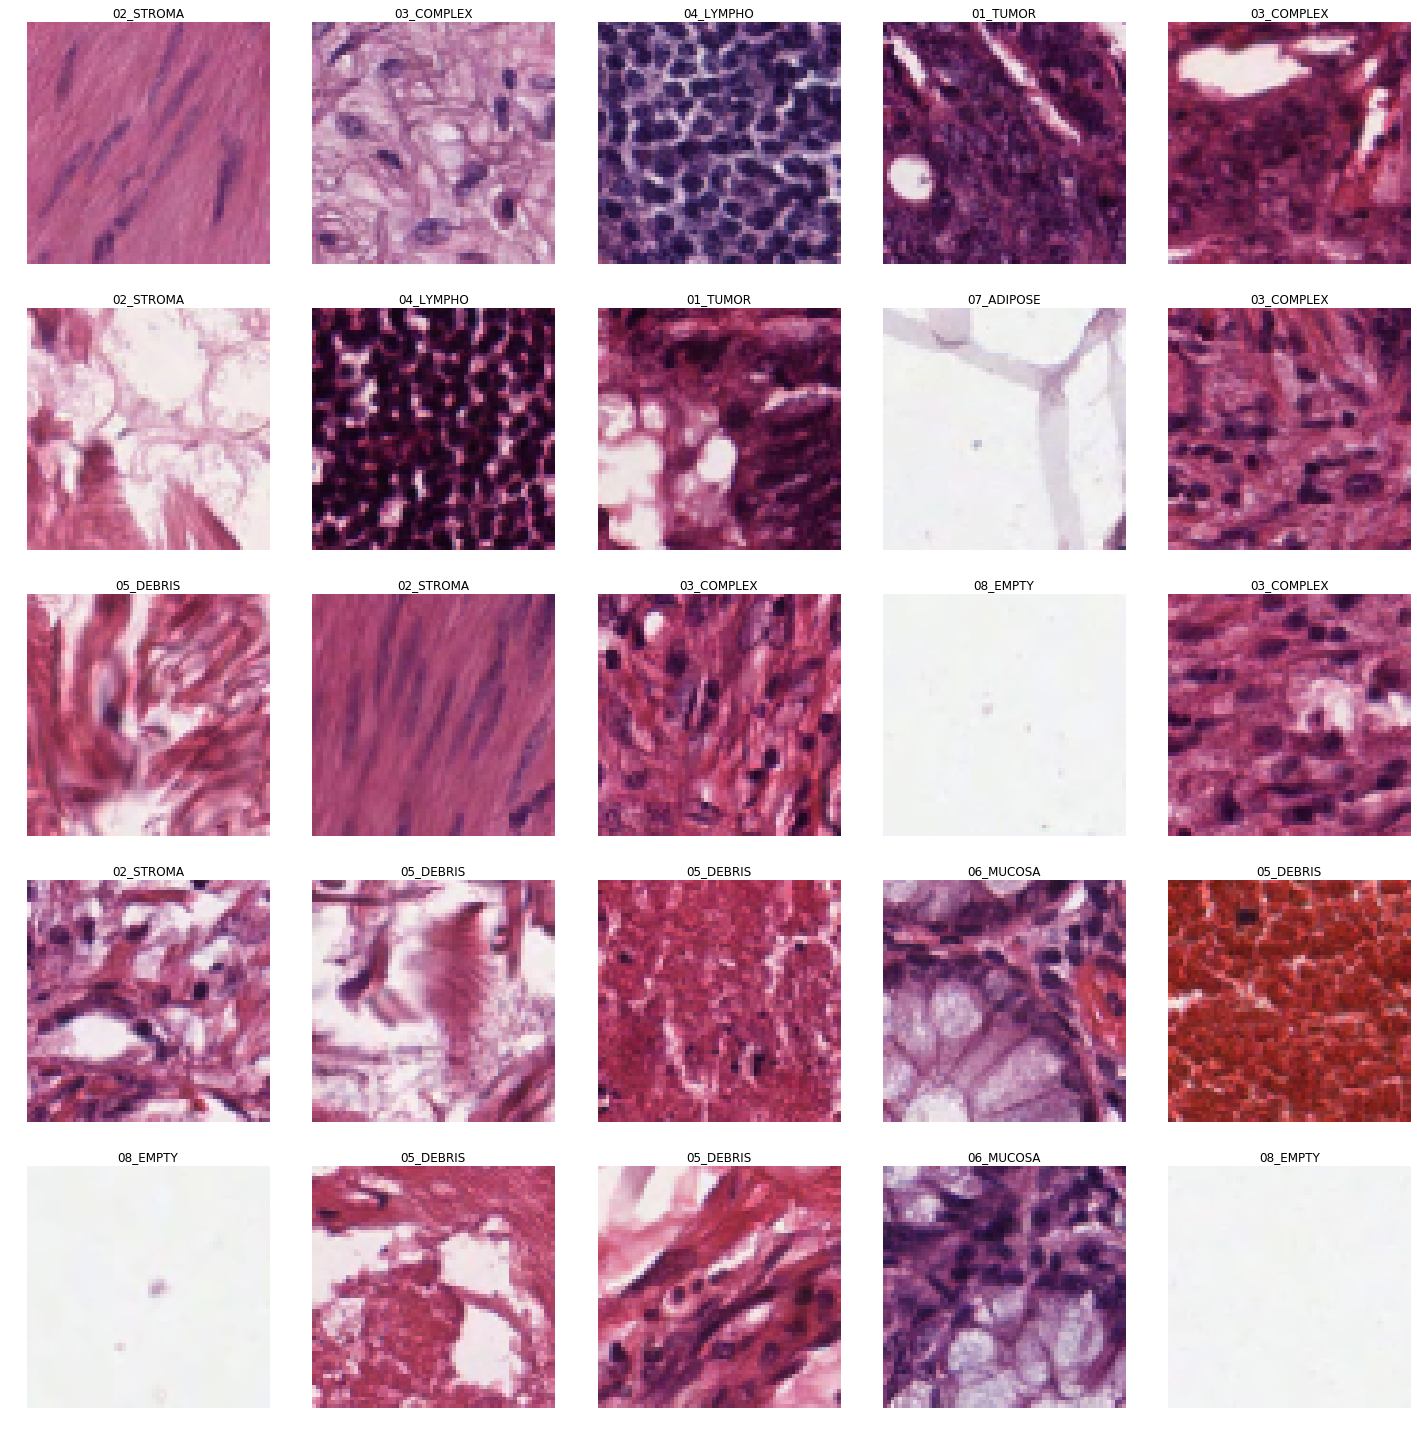

In [99]:
data.show_batch()

### Building our model
We will first compare a:
* Resnet50
* DenseNet169

With default values

### ResNet50

In [102]:
# Creating our first arch (pre-trained)
arch_resnet = models.resnet50

In [110]:
# Creating out learned
learn = create_cnn(data, arch_resnet, metrics=[error_rate, accuracy])

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


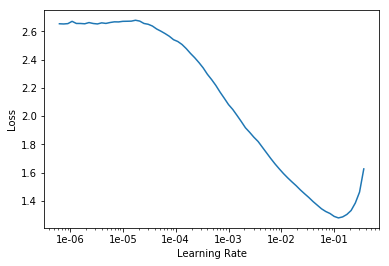

In [104]:
# Let's find optimal learnign rate
learn.lr_find()
learn.recorder.plot()

In [111]:
# Picking learning rate
# lr = 3e-2
lr = 3e-2

In [112]:
# Let's train - beat .942
learn.fit_one_cycle(3, slice(lr))

epoch,train_loss,valid_loss,error_rate,accuracy
1,0.574539,0.478845,0.133000,0.867000
2,0.408594,0.217931,0.068000,0.932000
3,0.262897,0.162195,0.058000,0.942000


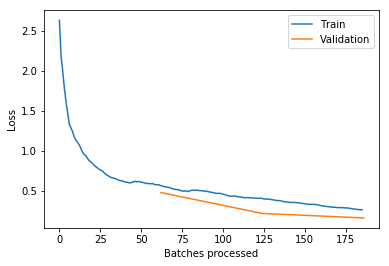

In [113]:
learn.recorder.plot_losses()

### DenseNet169

In [114]:
arch_densenet = densenet169

In [115]:
learn = create_cnn(data, arch_densenet, metrics=[error_rate, accuracy])

/opt/conda/envs/fastai/lib/python3.6/site-packages/torchvision/models/densenet.py:212: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  nn.init.kaiming_normal(m.weight.data)
Downloading: "https://download.pytorch.org/models/densenet169-b2777c0a.pth" to /root/.torch/models/densenet169-b2777c0a.pth
100%|██████████| 57365526/57365526 [00:03<00:00, 15289018.71it/s]


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


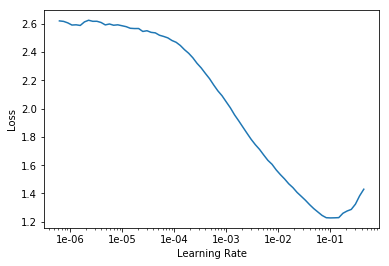

In [116]:
learn.lr_find()
learn.recorder.plot()

In [117]:
lr = 1e-2

In [118]:
learn.fit_one_cycle(3, slice(lr))

epoch,train_loss,valid_loss,error_rate,accuracy
1,0.447238,0.298599,0.098000,0.902000
2,0.296366,0.187547,0.070000,0.930000
3,0.199980,0.139523,0.047000,0.953000


## Conclusion 
So far from testing both **ResNet50** and **DenseNet169** we can see that DenseNet performs better. We will further experiment with a larger DenseNet Model & larger ResNet Model 

The next step would after selecting a larger model would be training much longer, adding regularization for better generalization

### DenseNet201

In [144]:
arch_densenet201 = densenet201

In [155]:
learn = create_cnn(data, arch_densenet201, metrics=[error_rate, accuracy])

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


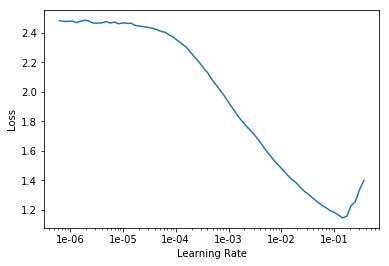

In [123]:
learn.lr_find()
learn.recorder.plot()

In [156]:
lr = 7e-3

In [157]:
# beat - .956
learn.fit_one_cycle(10, slice(lr), wd=1e-5)

epoch,train_loss,valid_loss,error_rate,accuracy
1,0.585900,0.327365,0.100000,0.900000
2,0.325743,0.234076,0.078000,0.922000
3,0.272483,0.239181,0.085000,0.915000
4,0.228727,0.161226,0.054000,0.946000
5,0.172224,0.144058,0.047000,0.953000
6,0.132206,0.152427,0.049000,0.951000
7,0.096239,0.109617,0.039000,0.961000
8,0.074996,0.115520,0.031000,0.969000
9,0.065991,0.104075,0.030000,0.970000
10,0.058072,0.111432,0.029000,0.971000


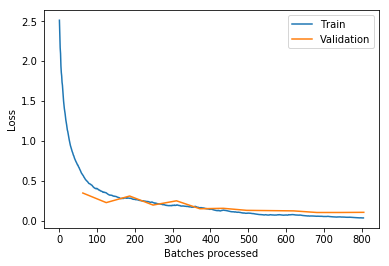

In [148]:
learn.recorder.plot_losses()

### ResNet152

In [138]:
arch_resnet152 = models.resnet152

In [139]:
learn = create_cnn(data, arch_resnet152, metrics=[error_rate, accuracy])

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


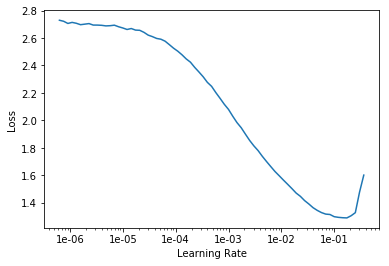

In [140]:
learn.lr_find()
learn.recorder.plot()

In [142]:
lr = 7e-3

In [143]:
learn.fit_one_cycle(3, slice(lr))

epoch,train_loss,valid_loss,error_rate,accuracy
1,0.518036,0.303864,0.109000,0.891000
2,0.332534,0.194154,0.064000,0.936000
3,0.214049,0.182476,0.060000,0.940000


# Conclusions & Next Steps
From running our experiment, a **DenseNet201** seems to outperform a **ResNet152** architecture. 

For each experiment the only change was in Learning Rate. By using ```lr_find()``` we are able to find the optimal learning rate for each different architecture. 

### Next steps:
To aim for even higher accuracy I would do the following:
* Train DenseNet201 with higher epochs
    * Experiment with high epochs, if you notice overfitting then stop there (we will add regularization)
* Now to generalize much better I would experiment with:
    * Weight Decay - grid search
    * Batch Size - larger = more regularization
    * Momentum - test (0.90, 0.99)
    * Dropout - by default dropout (ps = 0.5) thus I would do a grid search [0, 0.1, 0.2, 0.3, 0.4, 0.6]
* Once I have found optimal parameters I would:
    * unfreeze() and train 3 more epochs
    * create new databunch object, this time with image_size=150
    * train the model (same model) with this new databunch 
        * Freeze layers
        * Train till over fitting
        * Unfreeze
        * Train for another 3 epochs
* Use Test Time Augmentation 